In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/merged_dataset_v2.csv'

In [3]:
import pandas as pd

df = pd.read_csv(file_path, index_col = 0)
df.head()

,Unnamed: 0,text,labels
0,0,Bu tətbiq niyə nömrəyə kod göndərmirr,0
1,1,Biz evin qida məhsullarini bravodan alırıq çox...,1
2,2,Pisdir çox exlaqsizliq bas alıb gedir,0
3,3,Qulag asmiram amma merifetli qardasdi Allah ca...,1
4,4,m10 kimi rahat gözəl tətbiq yoxdur,1


In [ ]:
print(df.columns)

Index(['text', 'labels'], dtype='object')


In [ ]:
df['labels'].value_counts()

,count
labels,
0,14000
1,14000


In [4]:
from sentence_transformers import SentenceTransformer

# LaBSE modelini yükle
model = SentenceTransformer('sentence-transformers/LaBSE')

# Temizlenmiş metinleri al
texts = df['text'].tolist()

# Embedding çıkar (batch size isteğe göre artırılabilir)
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/870 [00:00<?, ?it/s]

In [5]:
import numpy as np

# NumPy array'e dönüştürmek istiyorsan:
embeddings = np.array(embeddings)

# Şekli kontrol et (satır sayısı, embedding boyutu)
print(embeddings.shape)

(55673, 768)


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['labels'])

# İstersen sınıf isimlerini görelim
print(label_encoder.classes_)

[0 1]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [12]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1, 3],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1]
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(
        tree_method='gpu_hist',
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_grid=params,
    scoring='f1_macro',
    cv=3,                    # 🔥 Daha sağlam test
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
16 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", lin

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8], 'gamma': [0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [6, 8],
                         'min_child_weight': [1, 3], 'n_estimators': [300],
                         'reg_alpha': [0], 'reg_lambda': [1],
                         'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [14]:
print(grid.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}


              precision    recall  f1-score   support

    negative       0.77      0.80      0.78      4568
    positive       0.86      0.83      0.84      6567

    accuracy                           0.82     11135
   macro avg       0.81      0.82      0.81     11135
weighted avg       0.82      0.82      0.82     11135

Confusion Matrix:
[[3671  897]
 [1124 5443]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


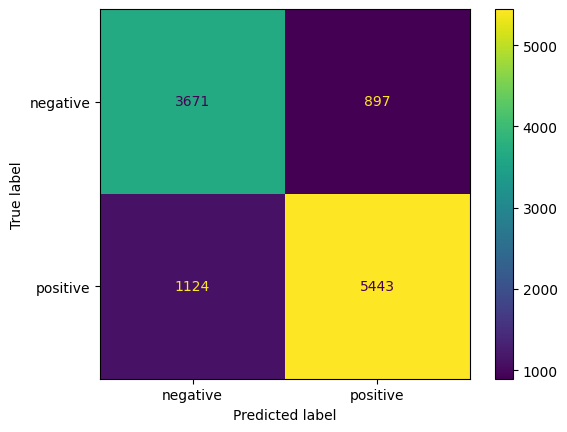

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# GridSearch sonrası en iyi modeli kullan
best_model = grid.best_estimator_

# Test verisi için tahmin yap
y_pred = best_model.predict(X_test)

# Sınıf isimleri
target_names = ["negative", "positive"]

# Sınıflandırma raporu
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix yazdır
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Görselleştirme
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()

In [15]:
import joblib
joblib.dump(grid.best_estimator_, "/content/drive/MyDrive/Colab Notebooks/Research Techniques II/labse_xgboost/labse_xgboost_model.pkl")

['/content/drive/MyDrive/Colab Notebooks/Research Techniques II/labse_xgboost/labse_xgboost_model.pkl']

In [16]:
import json
with open("/content/drive/MyDrive/Colab Notebooks/Research Techniques II/labse_xgboost/labse_xgboost_best_params.json", "w") as f:
    json.dump(grid.best_params_, f)